# US Airline Twitter Sentiment Analysis

## Topic
Sentiment Analysis – One of the most popular projects in the industry. Every customer facing industry (retail, telecom, finance, etc.) is interested in identifying their customers’ sentiment, whether they think positive or negative about them.

The dataset contains more than 14000 tweets data samples about six airline companies, classified into 3 types: positive, negative, neutral. It contains information such as :
- Tweet id : identification number of the tweet
- airline sentiment : the general sentiment the client has about the company i.e :positive, negtive or neutral
- airline sentiment confidance : how confidant is the client about their opinion
- negative reason : the reason why the subject had a negative experience
- negative reason confidance : how confidant the subject is about their negative reason
- airline : the name of the company reviewed
- retweet count : how many time was the tweet retweeted
- text :  the actual comment the client wrote
- the time, time zone and geolocation of the tweet

I'll be only using text and airline sentiment for the ML models. This is a multiclass classification problem (we need to be able to classify a comment as positive, negative or neutral). I'll be using various NLP techniques to clean and process the data.

## Objectives
- Clean and process the data using NLP techniques
- Build and experiment different models able to analyse the sentiment of a tweet.
- Compare models' performances and choose the best one for this project

## Summary
- Importing libraries
- Uploading the data set
- Checking missing values and unique categories
- Exploratory data analysis
- Feature engineering 
- Text preprocessing (bags of words)
- Splitting tht train and test sets
- Logistic Regression :
   - Roc curve
   - Classification report
- Random Forest Classifier:
   - Roc curve
   - Classification report
- XGBoost classifier :
   - Roc curve
   - Classification report
- SVM / SVC :
   - Roc curve
   - Classification report
- Comparing models' performances
- Conclusion


## Importing libraries

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime as dt
sns.set(rc = {'figure.figsize':(15,8)})

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer
import string
import regex as re
nltk.download('stopwords')
from sklearn.preprocessing import label_binarize
from itertools import cycle

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import  recall_score, classification_report, accuracy_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from pprint import pprint
from collections import Counter


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Uploading the data set

In [2]:
tweets = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\Sentiment_analysis\Tweets.csv', sep =",")
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

The dataset contains numerical and cetegorical features with 14 640 rows. It gives us information about the tweets such as their ids,  location, overall sentiment and how confident the client is about it, negative reasons and their confidence level, the timestamp of when the tweet was created and most importantly the test written by the reviewers.

### Checking missing values

<AxesSubplot:>

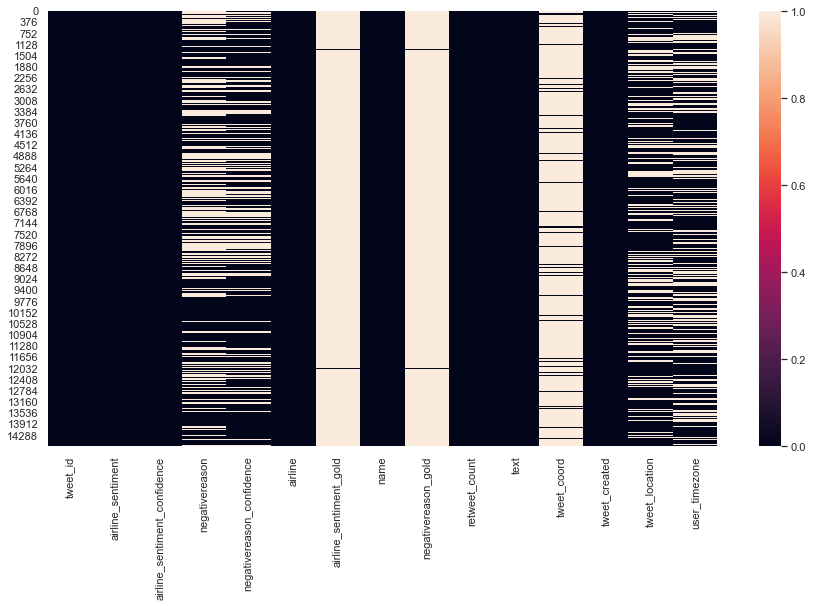

In [4]:
sns.heatmap(tweets.isnull())

There seems to be a lot os missing data especially in the sentiment gold section and tweet coordinates and location. Luckily these columns aren't very important to this study.

In [5]:
def table (df):
    missing = df.isnull().sum()
    missing_perc = df.isnull().sum() * 100/ len(df)
    missing_df = pd.concat([missing,missing_perc], axis = 1)
    missing_df = missing_df.rename(columns={0:"n missing",1:"n percentage"})
    return missing_df

In [6]:
missing = table(tweets)
missing = missing.round(1)
missing.drop(missing.index[(missing["n percentage"] == 0.0)],axis = 0 , inplace = True)
missing = missing.sort_values(by = ["n percentage"],ascending = False)
missing = missing.reset_index()
missing

,index,n missing,n percentage
0,negativereason_gold,14608,99.8
1,airline_sentiment_gold,14600,99.7
2,tweet_coord,13621,93.0
3,negativereason,5462,37.3
4,user_timezone,4820,32.9
5,tweet_location,4733,32.3
6,negativereason_confidence,4118,28.1


I will go ahead and delete the column that have more than 90% missing values, the ids column, names and timezones for now. 

In [7]:
tweets.drop(tweets.columns[[8,6,7,14,11, 0]], axis=1, inplace=True)

### Checking unique categories

In [8]:
objects = tweets.select_dtypes("object")
objects.describe().transpose()

,count,unique,top,freq
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
text,14640,14427,@united thanks,6
tweet_created,14640,14247,2015-02-24 09:54:34 -0800,5
tweet_location,9907,3081,"Boston, MA",157


Here we see the number of unique categories per categorical feature. I'll be using them in dataviz.

## Exploratory data analysis

[Text(0.5, 1.0, 'Number of reviews by airline ')]

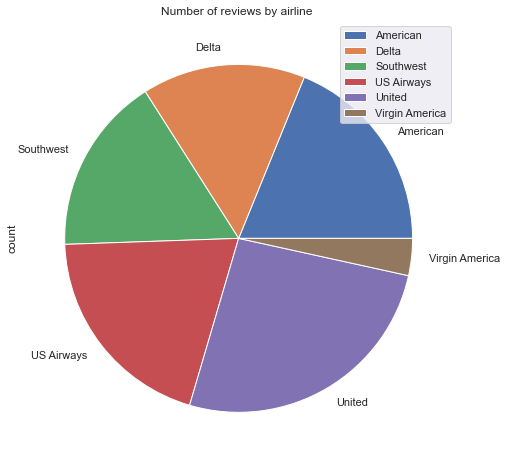

In [9]:
airline = tweets.iloc[:,4]
count = count = [1 for i in range(len(tweets))]
data = pd.DataFrame()
data["count"] = count
data["airline"] = airline
data = data.groupby(["airline"]).sum()
data.plot.pie(y="count").set(title="Number of reviews by airline ")

The pie plot shows the number of reviews by airline company. We notice that most reviews were written for United airlines, and the least for Virgin America airlines, while the others share almost equally the rest.

[Text(0.5, 1.0, 'Sentiment by airline')]

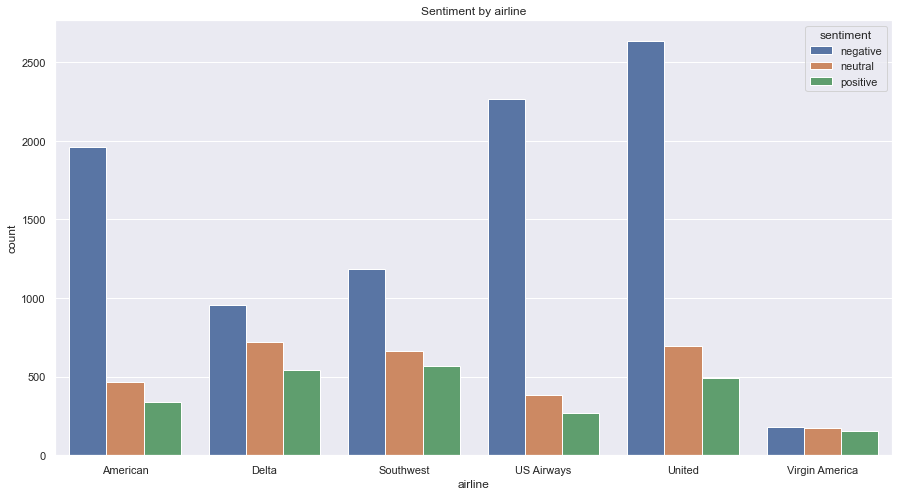

In [10]:
airline = tweets.iloc[:,4]
count = count = [1 for i in range(len(tweets))]
sent = tweets.iloc[:,0]
data = pd.DataFrame()
data["count"] = count
data["airline"] = airline
data["sentiment"] = sent
data = data.groupby(["airline","sentiment"]).sum().reset_index()
sns.barplot(data=data, x="airline",y="count",hue="sentiment").set(title="Sentiment by airline")

The bar plot above shows us the sentiment by airline. Overall the dominant feeling is negative especially for United airlines, US airways and American airlines. By contrast Virgin America airlines have an almost equal amount of negative reviews as it does of neutral and positive reviews.

[Text(0.5, 1.0, 'negtive reasons')]

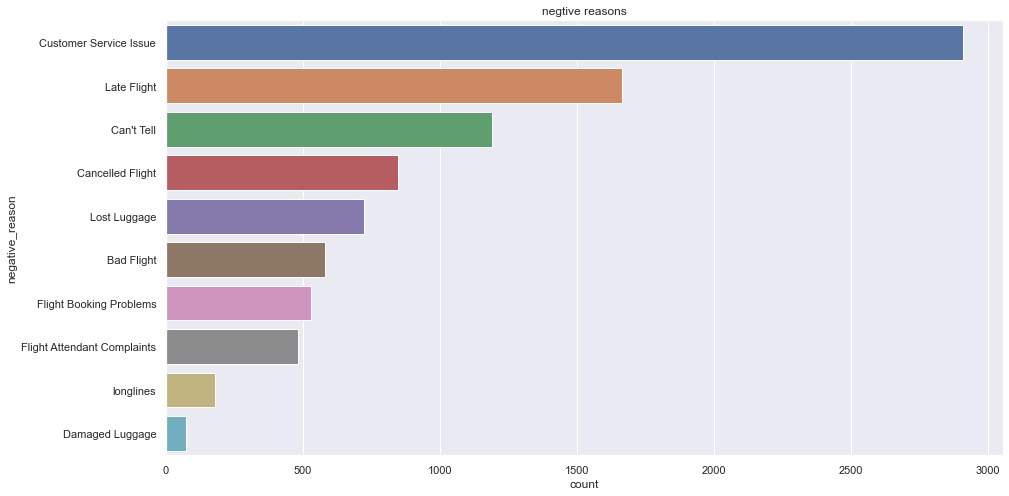

In [11]:
rea = tweets.iloc[:,2]
count = count = [1 for i in range(len(tweets))]
data = pd.DataFrame()
data["count"] = count
data["negative_reason"] = rea
data = data.groupby("negative_reason").sum().reset_index()
data = data.sort_values(by="count",ascending = False)
sns.barplot(data=data, x="count", y="negative_reason").set(title="negtive reasons")

Here we see the negative resons cited by people, the most dominant one is customer service followed by flights delay and cancellation and luggage loss.

[Text(0.5, 1.0, 'Retweets by sentiment ')]

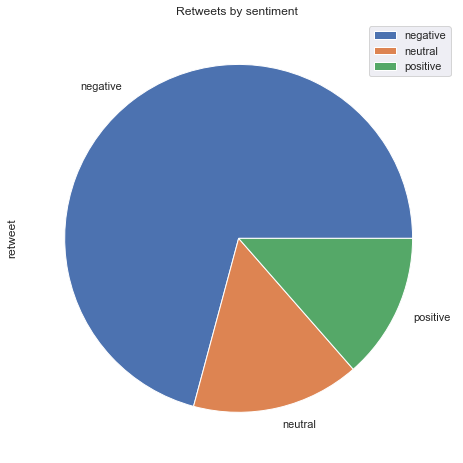

In [12]:
sent = tweets.iloc[:,0]
ret = tweets.iloc[:,5]
data = pd.DataFrame()
data["sentiment"] = sent
data["retweet"] = ret
data = data.groupby("sentiment").sum()
data.plot.pie(y="retweet").set(title="Retweets by sentiment ")

Then we see the amount of retweets by sentiment and we notice that negative reviews are retweeted more often, but this might be because negative tweets are dominant in the first place.

[Text(0.5, 1.0, 'Amount of tweets by location')]

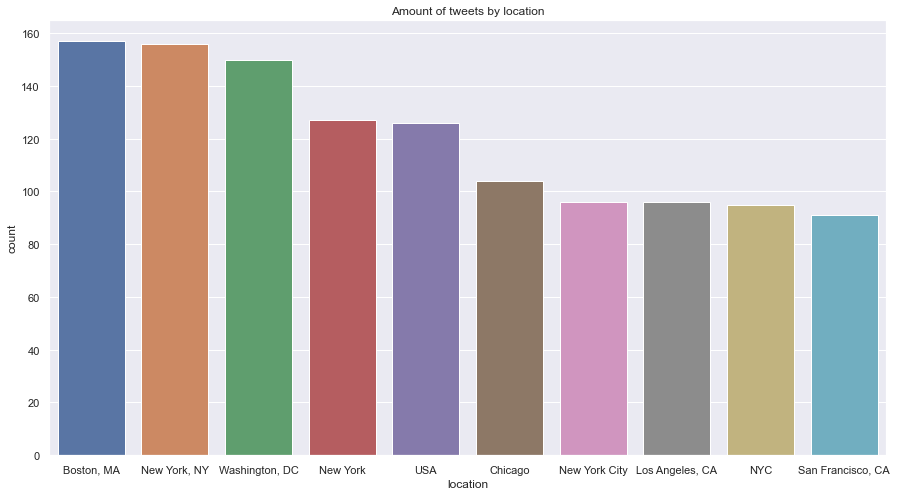

In [13]:
loc = tweets.iloc[:,8]
count = count = [1 for i in range(len(tweets))]
data = pd.DataFrame()
data["count"] = count
data["location"] = loc
data = data.groupby("location").sum().reset_index()
data = data.sort_values(by="count", ascending=False)
data = data.head(10)
sns.barplot(data = data,x="location", y="count").set(title="Amount of tweets by location")

Then we see the amount of tweets by location, we notice that New York exists more than once under differently spelled names and overall the top places from which tweets happen are New York, Washington, Boston, SF... because they are areas of high populations.

In [14]:
# Dropping the timestamp part 
def date_time(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d').dt.date
date_time(tweets,["tweet_created"])
tweets.sort_values(by = 'tweet_created', inplace = True)

In [15]:
date = tweets.iloc[:,7]
count = count = [1 for i in range(len(tweets))]
data = pd.DataFrame()
data["count"] = count
data["date"] = date

In [16]:
# Converting "tweet_created" column to datetime then int to group the ds by it
data["date"]= data['date'].astype('datetime64')
def datetime_to_int(dat, cols):
    for col in cols:
        dat[col] = dat[col].values.astype(np.int64)
datetime_to_int(data, ["date"])
data = data.groupby("date").sum().reset_index()

Text(0.5, 1.0, 'Number of tweets by time')

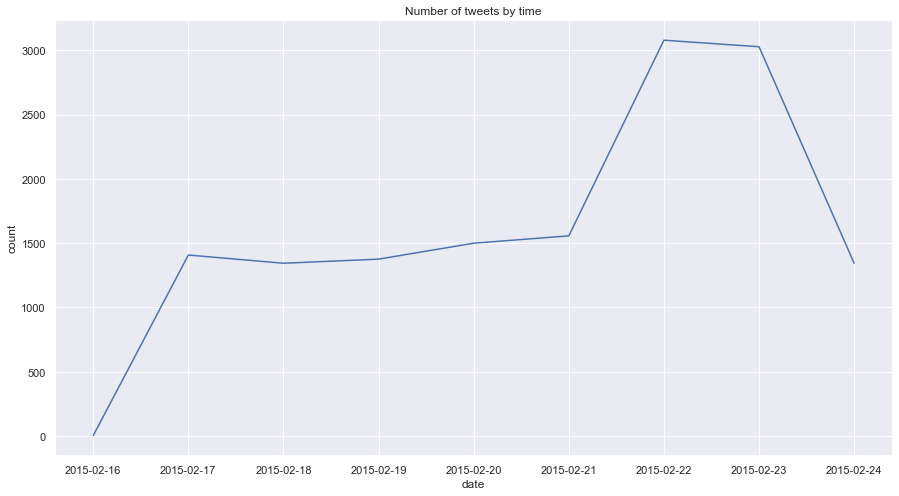

In [17]:
# Converting it back to datetime and ploting the time series
data["date"]= data['date'].astype('datetime64[ns]')
data = data.sort_values(by="date",ascending=True)
fig,ax = plt.subplots()
ax = sns.lineplot(data = data,  x="date", y="count")
ax.set_title("Number of tweets by time")

Here we've got the number of tweets by time and we notice a spike in tweets between the 22nd and 23rd of February 2015.

## Feature Engineering

In [18]:
tweets = tweets.drop(tweets[tweets['airline_sentiment_confidence']<0.5].index,axis=0)

In [19]:
tweets.shape

(14404, 9)

Here I've dropped rows for which confidence levels are below 0.5 because it basically means that the subject isn't sure of their choice. 

In [20]:
data = tweets.iloc[:,[0,6]]
data.head()

,airline_sentiment,text
4325,negative,@united yes. We waited in line for almost an h...
4324,negative,@united the we got into the gate at IAH on tim...
8965,neutral,@JetBlue's new CEO seeks the right balance to ...
8964,negative,@JetBlue is REALLY getting on my nerves !! 😡😡 ...
8823,negative,"@JetBlue flight 894, first officer not even at..."


Here I only kept the necessary columns to perform the analysis which are the sentiment (target) and text (predictor).

In [21]:
X = data.iloc[:,1]
y = data.iloc[:,0]

## Text preprocessing

<AxesSubplot:xlabel='text', ylabel='Count'>

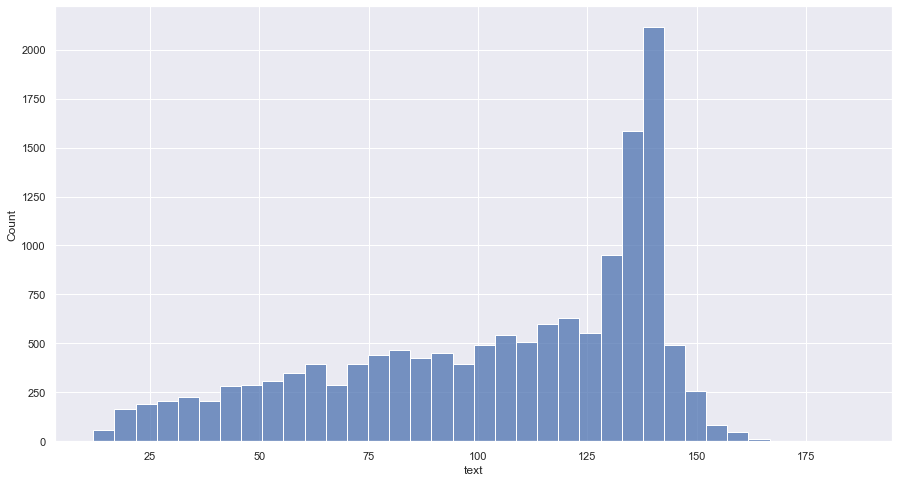

In [22]:
sns.histplot(tweets.text.str.len())

the displot above shows us the variations in the distribution of the text data. 

In [23]:
stop_words = stopwords.words('english')
punct = string.punctuation
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'\w+')

Here I stored the stop words, punctuation and stemmer in different functions.
- stop words are words that don't convey a lot of meaning such as : a, an, the, on, at, in..., this step will help reduce the size of the vocabulary in the dataset.
- punctuation in all its kinds like exclamation and question marks ...
- stemmer : which reduces the words into their stem or original format for example happier, happiness, happily all have the root happy, and this is done in order to reduce the size .
- regex tokenizer which splits the sentences into individual words.

In [24]:
cleaned_data=[]
for i in range(len(X)):
  tweet = re.sub('[^a-zA-Z]',' ',X.iloc[i])
  tweet = tweet.lower().split()
  tweet = [stemmer.stem(word) for word in tweet if (word not in stop_words) and (word not in punct)]
  tweet = ' '.join(tweet)
  cleaned_data.append(tweet)

In [25]:
cleaned_data

['unit yes wait line almost hour passeng left want wait past',
 'unit got gate iah time given seat close flight know peopl arriv wait',
 'jetblu new ceo seek right balanc pleas passeng wall greenfield daili report http co lm opxkxch',
 'jetblu realli get nerv nothappi',
 'jetblu flight first offic even airport wow unreal staff wait board announc delay',
 'southwestair old miss connect sleep oak get hotel dime rub wrong way late flight',
 'southwestair finest moment boston right',
 'southwestair bag st woman said would next flight ive got noth big wig help',
 'southwestair use point book rental car',
 'southwestair thank think straight',
 'southwestair thank take care today michel rock custom servic gate hou',
 'southwestair paid rental car go rd day',
 'southwestair thank',
 'southwestair thank expect wait long',
 'southwestair understand weather issu time cancel flight reinstat cancel flight hard updat noth',
 'despit mother natur best effort southwestair good humor folk got us home s

In this part I've done the following transformations : 
- I removed all the characters that are not letters , ie don't belong to a to z in lower or upper case.
- I converted everything to lower case and splitted them into sentences.
- If the word doesn't belong to stop words or punctuation I stemmed it i.e kept the original part of the word only.


### Bag of words approach

In [26]:
cv = CountVectorizer(max_features=5000,stop_words=['virginamerica','unit',"jetblu","southwestair","usairway","delta"])
X_fin = cv.fit_transform(cleaned_data).toarray()

In this part I used the bag of words method which creates a matrix table, where each row represents a sentence and each word will have separate column for itself that represents it’s frequency. This method doesn't respect the order in the sentence and analyses individual words, but it enables us to set a maximum number of features (I chose 5000) meaning that only the top 5 000 repeated words will be used. I also marked the names of the companies as stop words so they woudn't be taken into consideration)

### Encoding the target variable

In [27]:
y = y.str.replace('positive','1')
y = y.str.replace('negative','-1')
y = y.str.replace('neutral','0')

In [28]:
y = y.astype(str).astype(int)

Then I manually encoded the target by replacing positive with 1, negative with -1 and neutral with 0. Then transformed it from object to int.

## Splitting the train and test sets

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_fin, y, test_size=0.20, random_state=42)

Then I used the stratified split to get a similar portion of neutral, negative and positive comments in each of the train and test sets.

## Applying ML algorithms

### Logistic Regression

#### applying the model

In [30]:
log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(X_train,y_train)
reg_predictions = log_reg.predict(X_test)
reg_pred_proba = log_reg.predict_proba(X_test)

#### ROC Curve - One vs Rest (OvR)

In [31]:
# Getting the classes of the logistic regression model
reg_classes = log_reg.classes_
reg_classes

array([-1,  0,  1])

In [68]:
def plot_roc_curve(y_test, y_pred):
  
  n_classes = len(np.unique(y_test))
  y_test = label_binarize(y_test, classes=np.arange(n_classes))
  y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  #plt.figure(figsize=(10,5))
  plt.figure(dpi=600)
  lw = 2

  colors = cycle(["darkgreen", "yellow", "blue"])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label="ROC curve of class {0} ".format(i-1, roc_auc[i]),)

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver Operating Characteristic (ROC) curve")
  plt.legend()


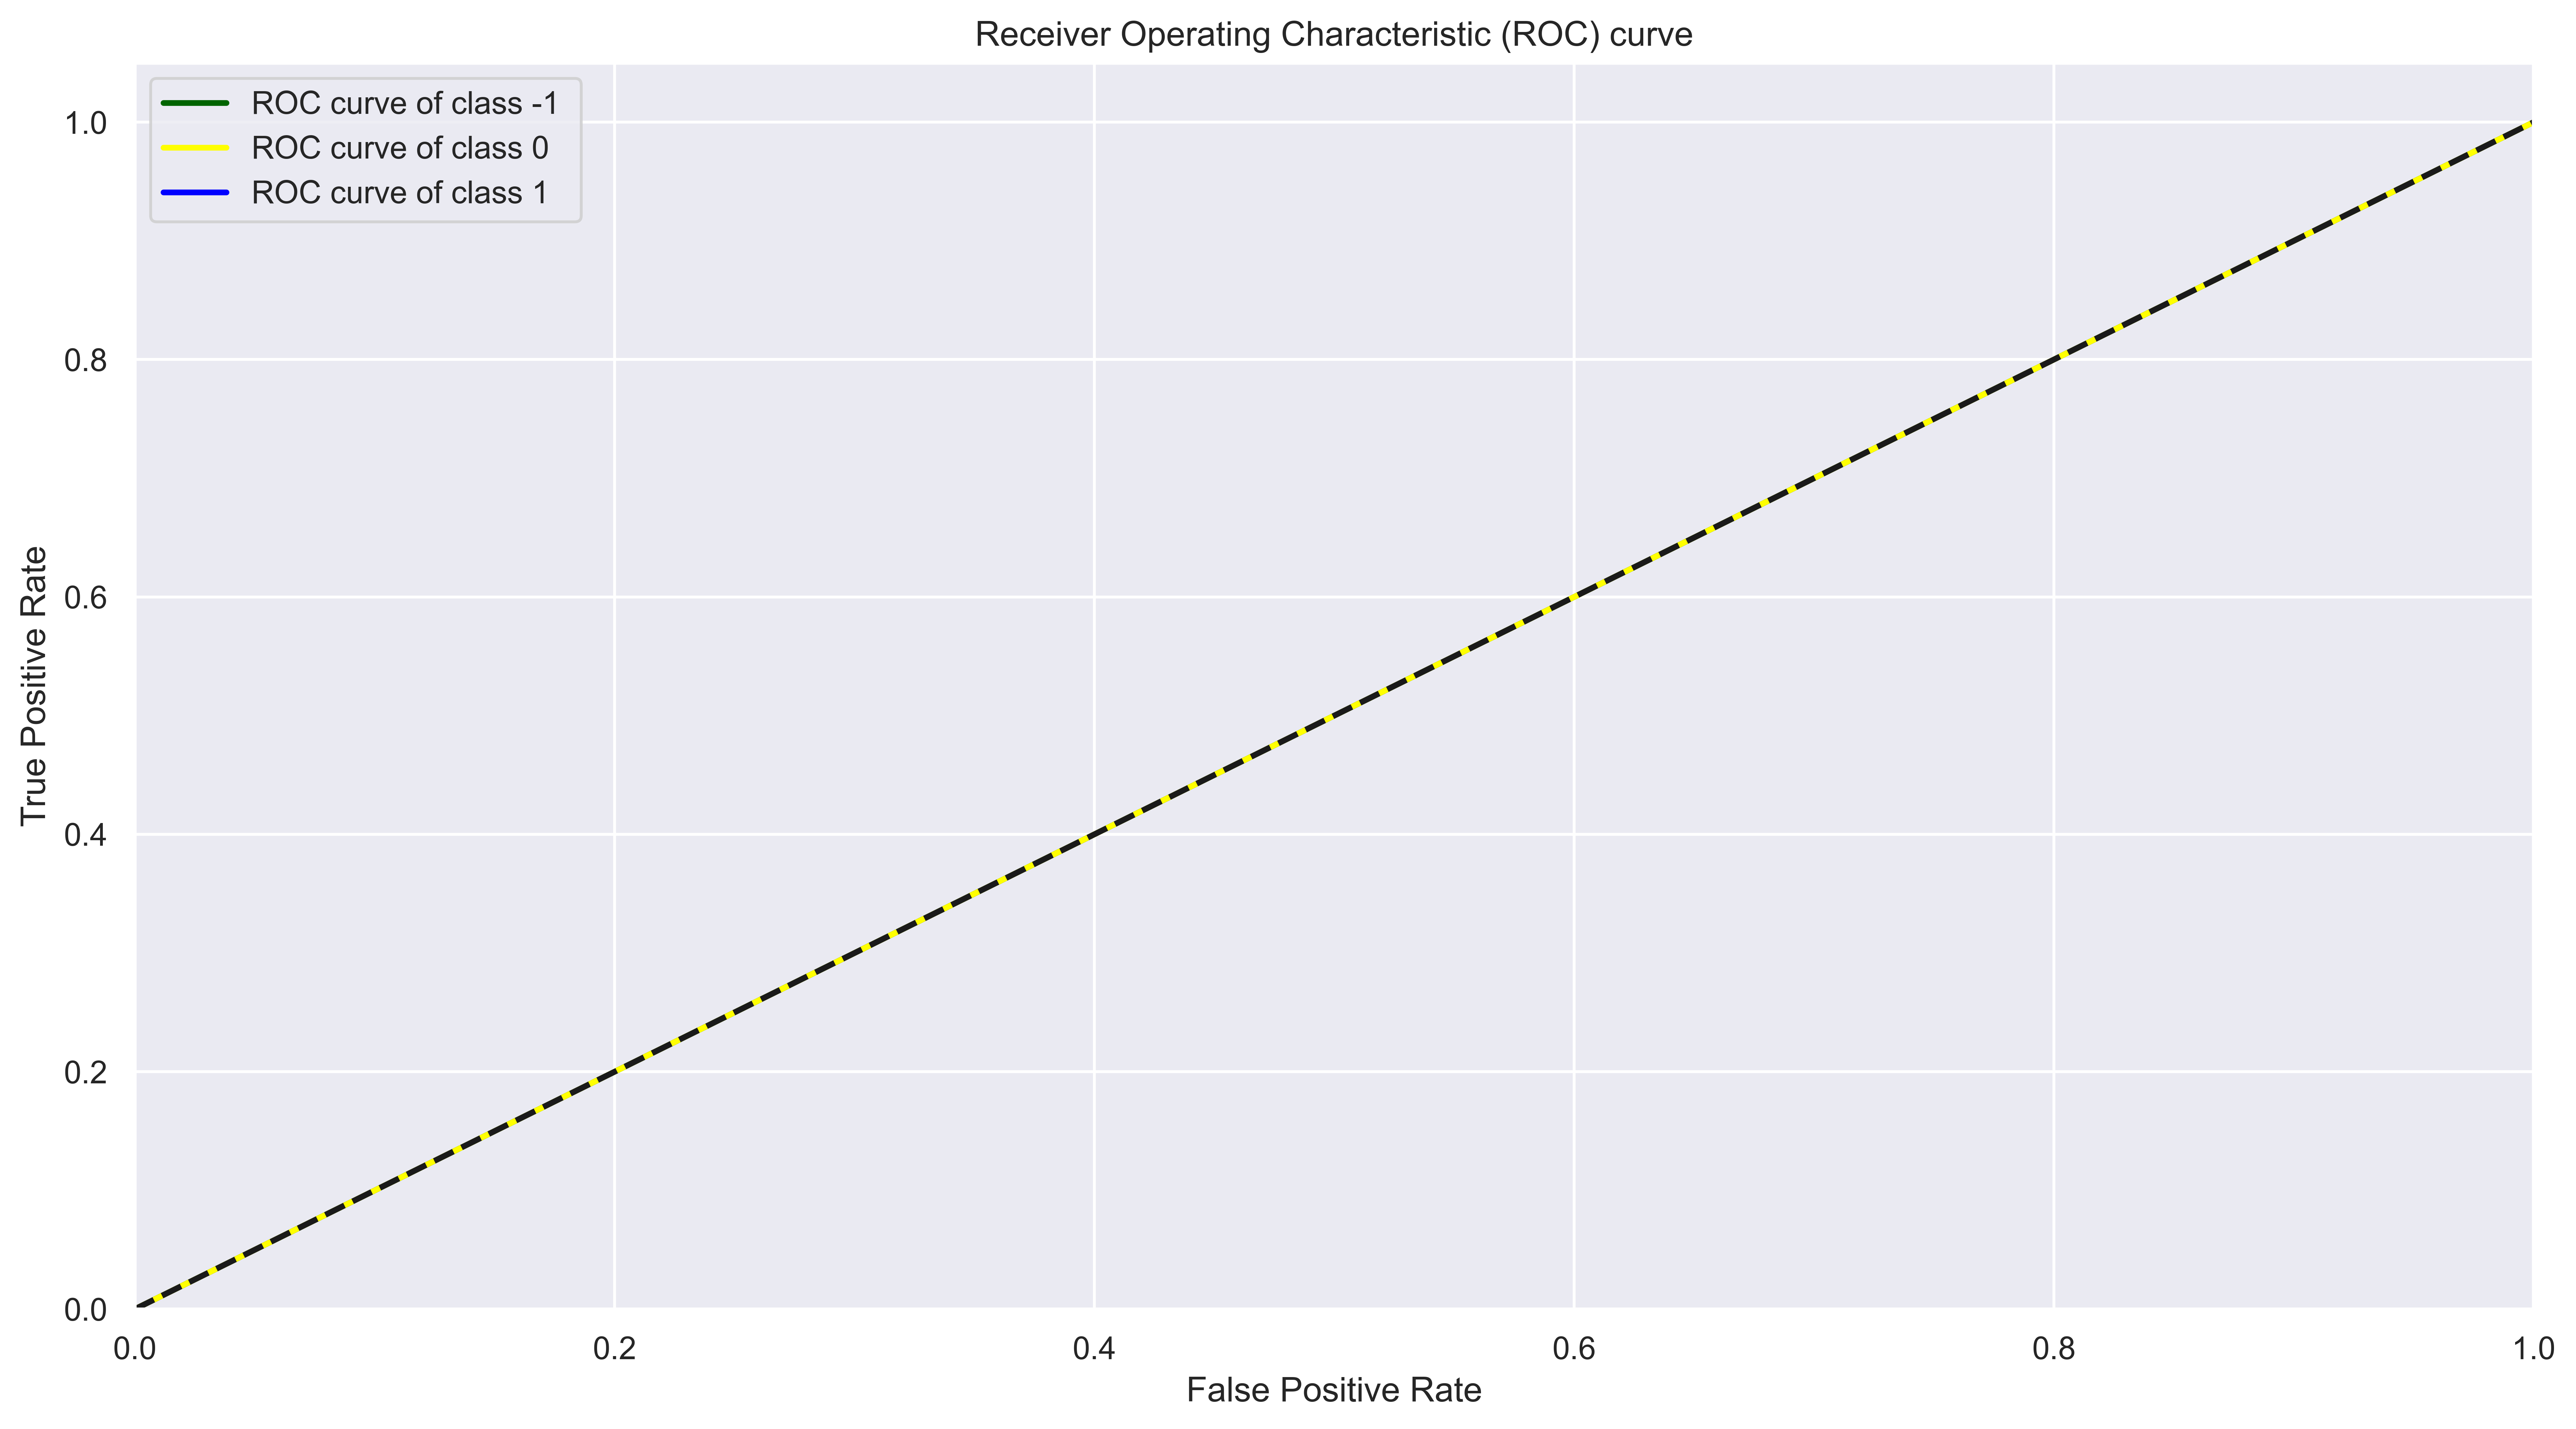

In [69]:
plot_roc_curve(y_test, reg_predictions)

The roc curve shows the results of the classification using the one over rest OvR method, which means that at each iteration it takes one category to be true and the rest to be false. it also tells us how competant is the model at distinguising categories. We notice that the curve is straight going through the middle for all classes, meaning that the model cannot really distinguish between the classes.

In [63]:
roc_score_reg = roc_auc_score(y_test,reg_pred_proba, multi_class='ovr', average='weighted')
roc_score_reg

0.7911750695372216

The weighted average roc auc score for the three classes is 0.79. The ROC AUC scores and the one-vs-rest (OvR) algorithm computes the average of the ROC AUC scores for each class against all other classes.

#### Classification report

In [64]:
cr_reg = classification_report(y_test,reg_predictions)
print(cr_reg)

              precision    recall  f1-score   support

          -1       0.64      1.00      0.78      1847
           0       0.00      0.00      0.00       577
           1       0.00      0.00      0.00       457

    accuracy                           0.64      2881
   macro avg       0.21      0.33      0.26      2881
weighted avg       0.41      0.64      0.50      2881



Above we see the classification report for the logistic regression  model, it seems to be doing okay only with negative comments and cannot differenciate the neutral and positive ones.

#### Accuracy/Precision/Recall scores

In [65]:
acc_reg = accuracy_score(y_test, reg_predictions)
acc_reg

0.6410968413745227

In [112]:
recall_reg = recall_score(y_test,reg_predictions, average='weighted')
recall_reg

0.6410968413745227

In [113]:
precision_reg = precision_score(y_test, reg_predictions, average='weighted')
precision_reg

0.41100516002038995

The accuracy score, precision and recall are all low.

### Random Forest Classifier

#### Grid Search

In [36]:
# Import the model with its default parameters
ran_for = RandomForestClassifier(random_state = 42)
pprint(ran_for.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [37]:
# Number of trees in random forest
n_estimators = [200,600]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [60,80]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

In [38]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [60, 80, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [2, 4],
 'min_samples_split': [5, 10],
 'n_estimators': [200, 600]}


#### Fit the model and make predictions

In [39]:
rf_random = RandomizedSearchCV(estimator = ran_for, param_distributions = random_grid, n_iter = 100, cv = 3,
                               verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [60, 80, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [200, 600]},
                   random_state=42, verbose=2)

In [40]:
# Extract the best parameters
best_rf = rf_random.best_estimator_
best_rf

RandomForestClassifier(max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [41]:
# Make predictions
rf_predictions = best_rf.predict(X_test)
rf_pred_proba = best_rf.predict_proba(X_test)

In [42]:
rf_classes = best_rf.classes_
rf_classes

array([-1,  0,  1])

#### ROC curve

In [70]:
def plot_roc_curve(y_test, y_pred):
  
  n_classes = len(np.unique(y_test))
  y_test = label_binarize(y_test, classes=np.arange(n_classes))
  y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  #plt.figure(figsize=(10,5))
  plt.figure(dpi=600)
  lw = 2

  colors = cycle([ "darkgreen", "yellow", "blue"])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label="ROC curve of class {0} ".format(i-1, roc_auc[i]),)

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver Operating Characteristic (ROC) curve")
  plt.legend()


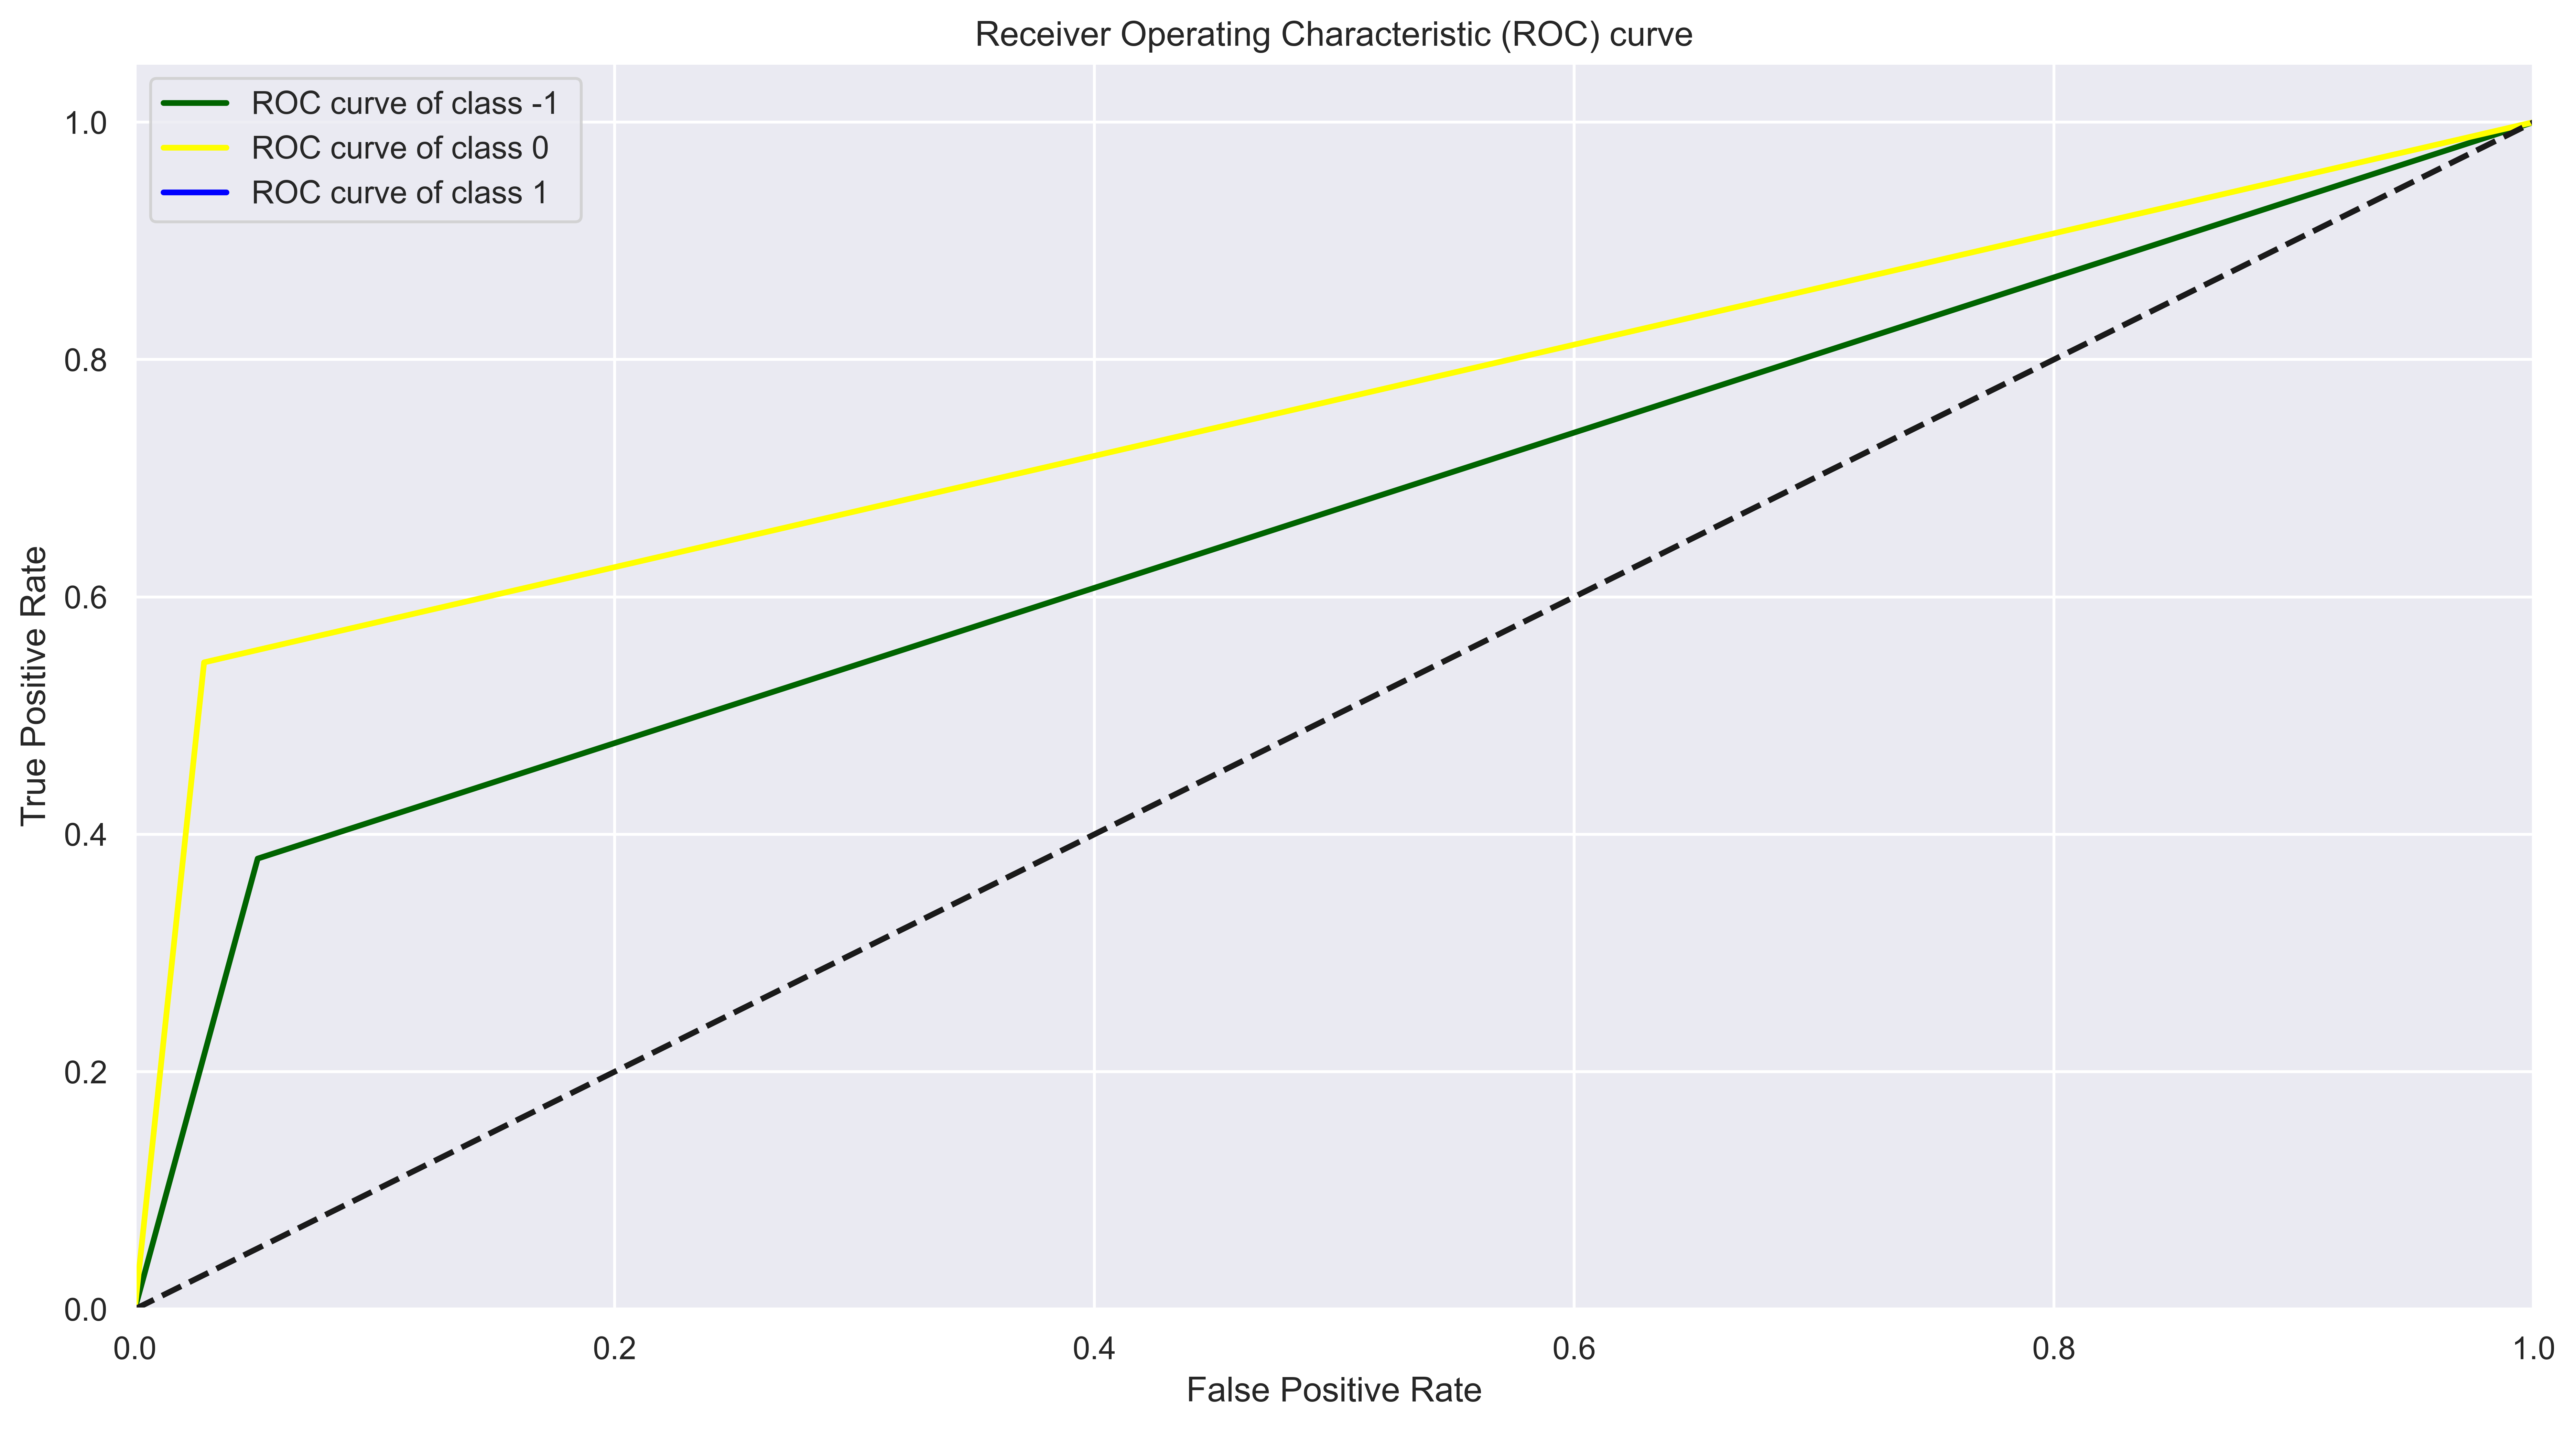

In [71]:
plot_roc_curve(y_test, rf_predictions)

The roc curve for RF model is showing better results compared to the base line model. It's ability to distinguish negative and neutral comments is better that that of LR, though it too cannot distinguish the good comments.

In [44]:
roc_score_rf = roc_auc_score(y_test,rf_pred_proba, multi_class='ovr', average='weighted')
roc_score_rf

0.8830801911055531

The weighted Auc Roc score is also higher

#### Classification Report

In [72]:
cr_rf = classification_report(y_test,rf_predictions)
print(cr_rf)

              precision    recall  f1-score   support

          -1       0.78      0.94      0.86      1847
           0       0.65      0.38      0.48       577
           1       0.78      0.54      0.64       457

    accuracy                           0.77      2881
   macro avg       0.74      0.62      0.66      2881
weighted avg       0.76      0.77      0.75      2881



The results of the classification report shows better precision for classes 1 and -1, with very bad recalls for classes 0 and 1.

#### Accuracy/Precision/Recall scores

In [73]:
acc_rf = accuracy_score(y_test, rf_predictions)
acc_rf

0.768136063866713

In [114]:
recall_rf = recall_score(y_test,rf_predictions, average='weighted')
recall_rf

0.768136063866713

In [115]:
precision_rf = precision_score(y_test, rf_predictions, average='weighted')
precision_rf

0.7567609605851034

And the accuracy, precision and recall are higher for RF

### XGBoost

#### Grid search

In [77]:
estimator = xgb.XGBClassifier(
    objective = 'multi:softmax',
    num_class =  3,
)

In [78]:
parameters = {
    'max_depth': [2,6],
    'n_estimators': [60, 100],
    'learning_rate': [0.1, 0.05]
}

In [79]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 3,
    verbose=True
)

#### Train the model and make predictions

In [80]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[18:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, num_class=3,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None,
                                     random_state=None, reg_alpha

In [86]:
best_xgb = grid_search.best_estimator_
xgb_predictions = best_xgb.predict(y_test)
xgb_pred_proba = best_xgb.predict_proba(y_test)

#### ROC curve

In [87]:
def plot_roc_curve(y_test, y_pred):
  
  n_classes = len(np.unique(y_test))
  y_test = label_binarize(y_test, classes=np.arange(n_classes))
  y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  #plt.figure(figsize=(10,5))
  plt.figure(dpi=600)
  lw = 2

  colors = cycle([ "darkgreen", "yellow", "blue"])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label="ROC curve of class {0} ".format(i-1, roc_auc[i]),)

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver Operating Characteristic (ROC) curve")
  plt.legend()


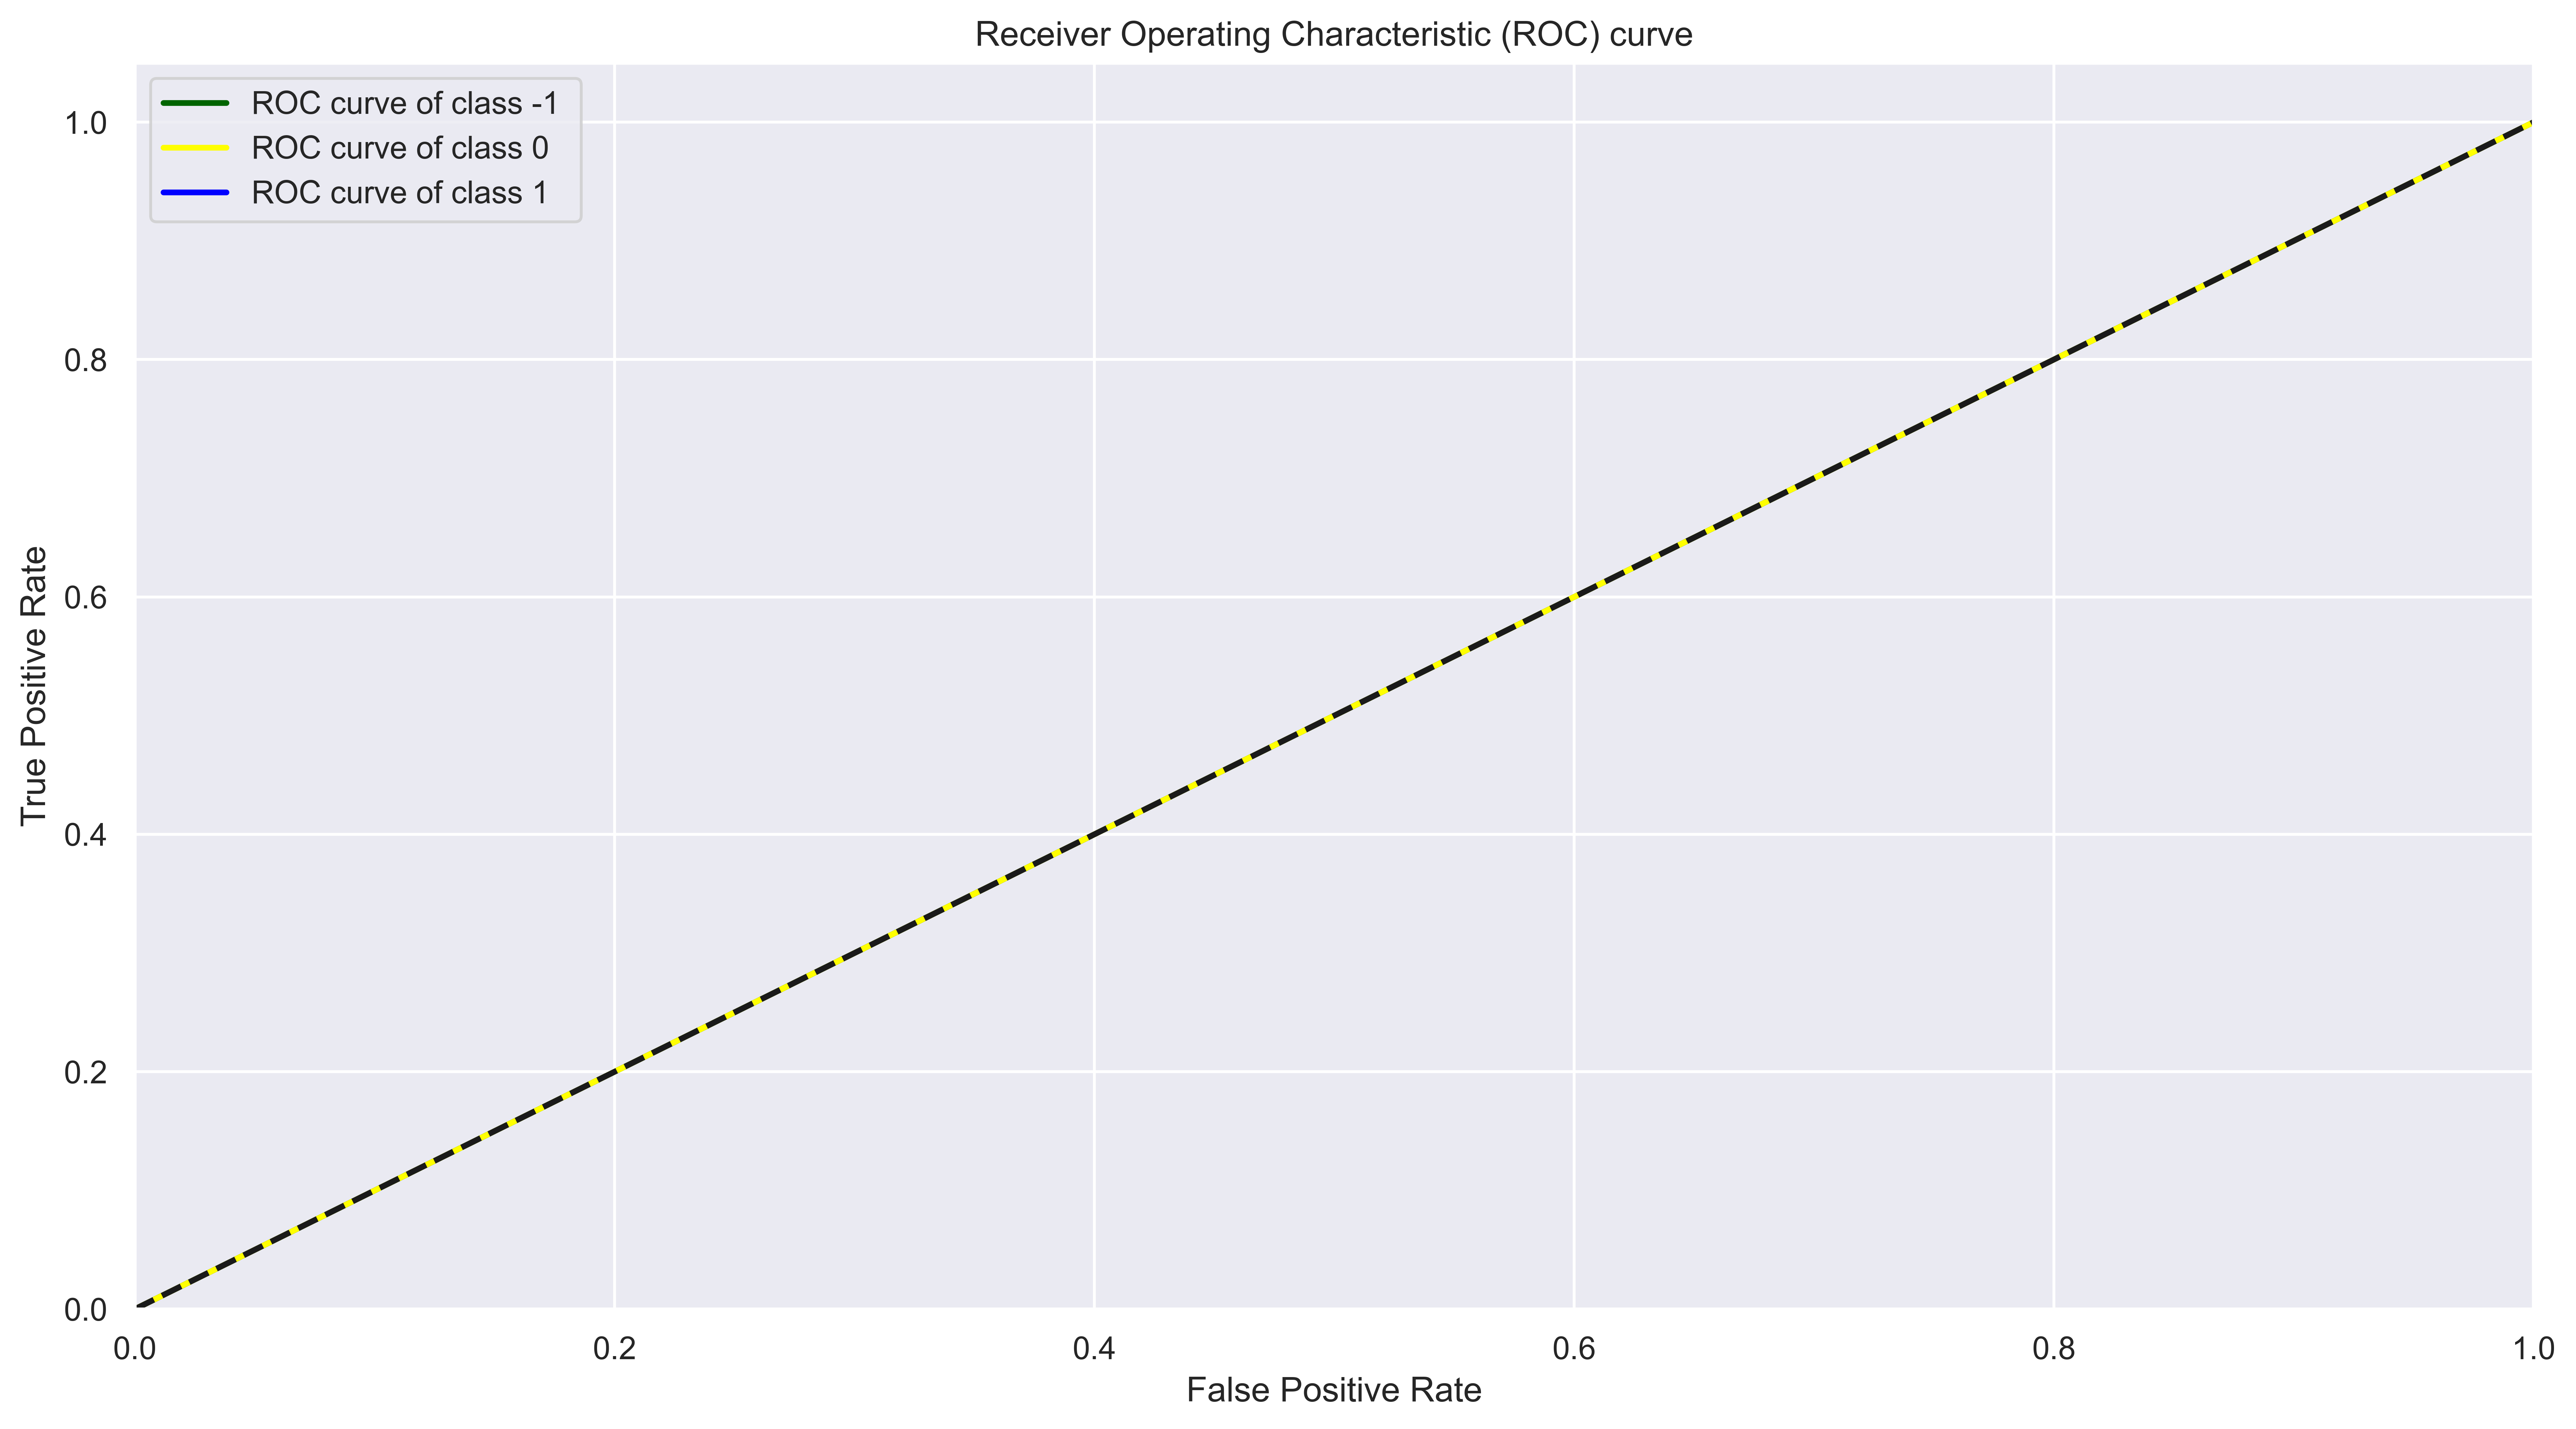

In [88]:
plot_roc_curve(y_test, xgb_predictions)

In [93]:
roc_score_xgb = roc_auc_score(y_test,xgb_pred_proba, multi_class='ovr', average='weighted')
roc_score_xgb

0.5

Looks like XGB is less performant for this data set, it cannot distinguish between any of the classes and its roc auc score is the lowest of all

#### Classification Report

In [94]:
cr_xgb = classification_report(y_test,xgb_predictions)
print(cr_xgb)

              precision    recall  f1-score   support

          -1       0.64      1.00      0.78      1847
           0       0.00      0.00      0.00       577
           1       0.00      0.00      0.00       457

    accuracy                           0.64      2881
   macro avg       0.21      0.33      0.26      2881
weighted avg       0.41      0.64      0.50      2881



The classification report too shows very low precision and recall scores.

#### Accuracy/Precision/Recall scores

In [95]:
acc_xgb = accuracy_score(y_test, xgb_predictions)
acc_xgb

0.6410968413745227

In [116]:
recall_xgb = recall_score(y_test,xgb_predictions, average='weighted')
recall_xgb

0.6410968413745227

In [117]:
precision_xgb = precision_score(y_test, xgb_predictions, average='weighted')
precision_xgb

0.41100516002038995

XGB's performence and score are as low as those of LR

### SVM - SVC

#### Grid Search

In [96]:
param_grid = {'C': [ 1, 10, 100],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 

grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.685 total time= 7.4min
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.678 total time= 9.0min
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.666 total time= 7.7min
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.671 total time= 8.7min
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.670 total time= 9.0min
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.790 total time= 5.0min
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.783 total time= 5.0min
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.767 total time= 4.8min
[CV 4/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.782 total time= 4.4min
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.778 total time= 5.0min
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.711 total time= 4.5min
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             verbose=3)

In [102]:
svm_predictions = grid.predict(X_test)

In [104]:
svm_classes = grid.classes_
svm_classes

array([-1,  0,  1])

#### ROC curve

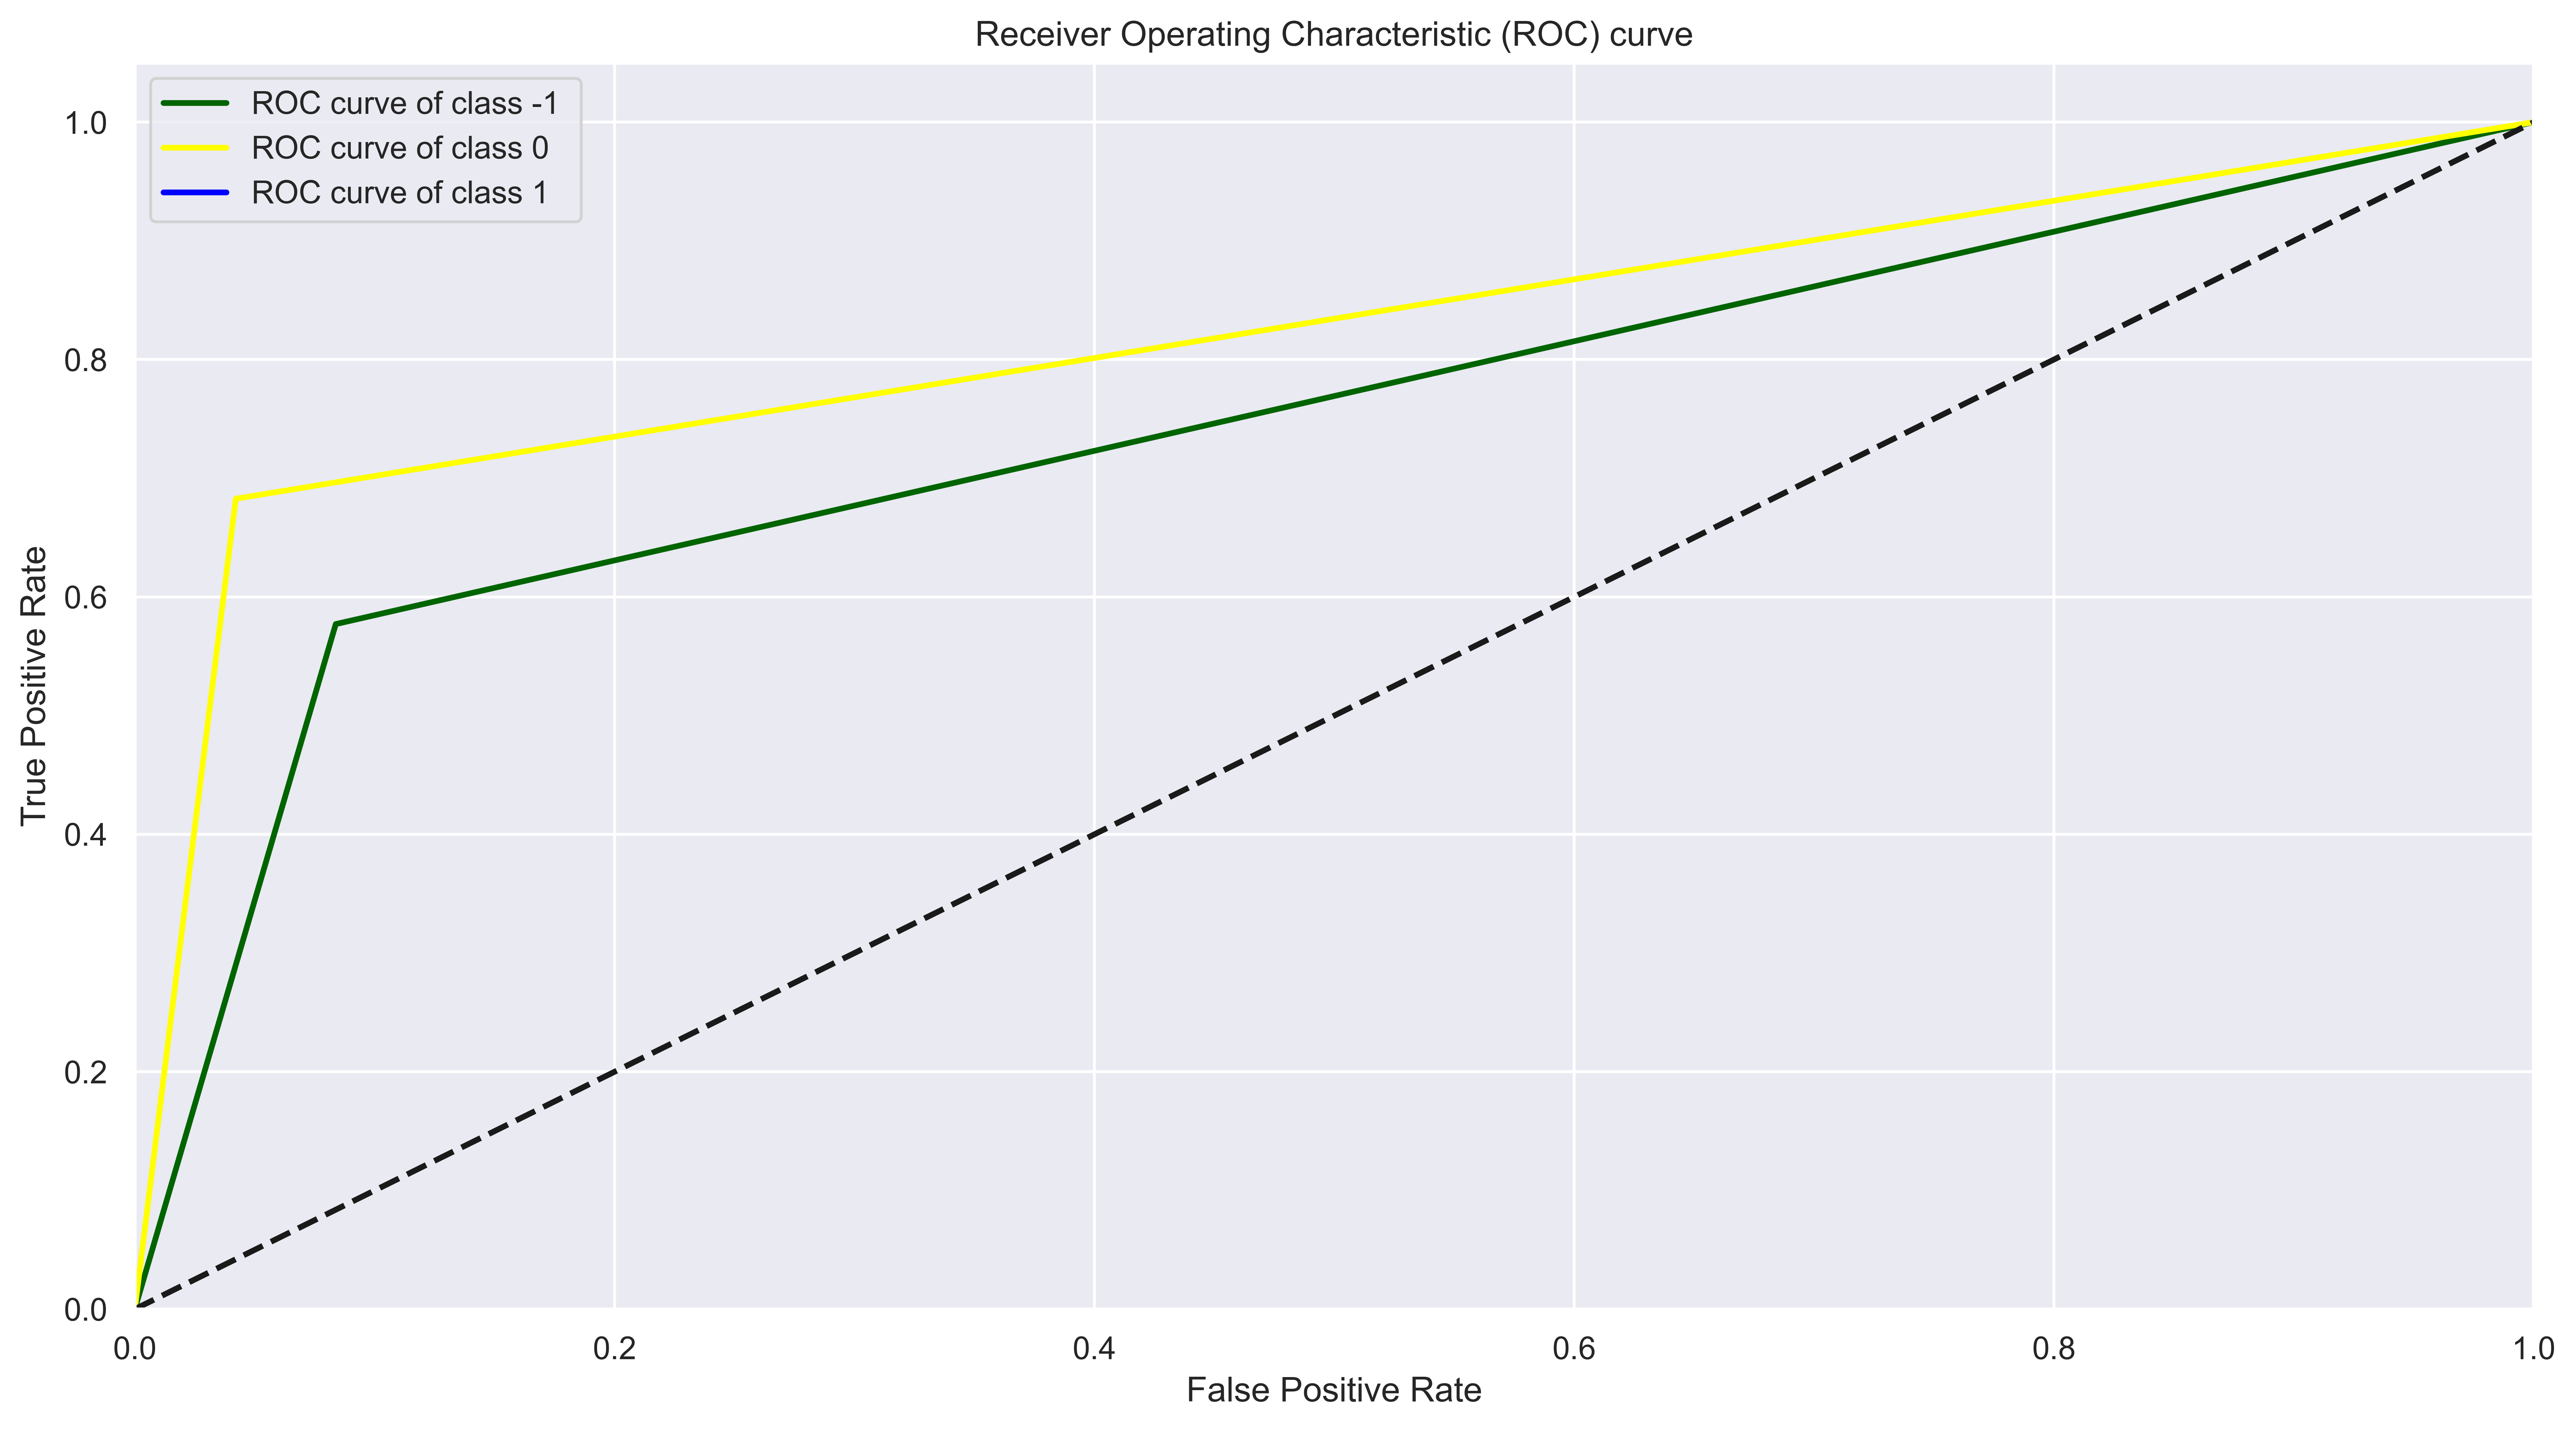

In [106]:
plot_roc_curve(y_test, svm_predictions)

The SVC model performed better than all the others. We see that it can distinguish the neutral and nagative comments better than the previous models, although, it too cannot distinguish positive reviews

#### Classification Report

In [108]:
cr_svm = classification_report(y_test,svm_predictions)
print(cr_svm)

              precision    recall  f1-score   support

          -1       0.85      0.89      0.87      1847
           0       0.63      0.58      0.60       577
           1       0.75      0.68      0.72       457

    accuracy                           0.80      2881
   macro avg       0.75      0.72      0.73      2881
weighted avg       0.79      0.80      0.79      2881



The recall and precision scores are the highest for the three categories than the other models.

#### Accuracy/Precision/Recall scores

In [109]:
acc_svm = accuracy_score(y_test, svm_predictions)
acc_svm

0.797292606733773

In [118]:
recall_svm = recall_score(y_test,svm_predictions, average='weighted')
recall_svm

0.797292606733773

In [119]:
precision_svm = precision_score(y_test, svm_predictions, average='weighted')
precision_svm

0.7919780450392171

The model's accuracy, precision and recall show their highest scores with SVM SVC

### Comapring algorithms' performances

In [120]:
scores = [["LR", acc_reg ,recall_reg, precision_reg],["RF", acc_rf ,recall_rf, precision_rf],
         ["XGB", acc_xgb ,recall_xgb, precision_xgb], ["SVC", acc_svm ,recall_svm, precision_svm]]
scores_df = pd.DataFrame(scores, columns = ["Model", "Accuracy", "Recall", "Precision"])
scores_df = scores_df.sort_values(by = "Precision",ascending = "False")
scores_df

,Model,Accuracy,Recall,Precision
0,LR,0.641097,0.641097,0.411005
2,XGB,0.641097,0.641097,0.411005
1,RF,0.768136,0.768136,0.756761
3,SVC,0.797293,0.797293,0.791978


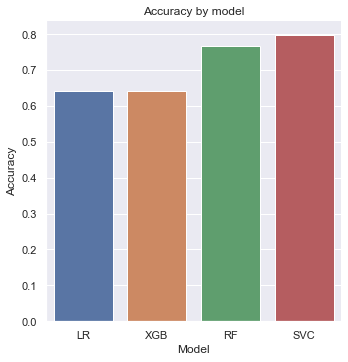

In [124]:
sns.catplot(data=scores_df, kind="bar",x ="Model", y="Accuracy").set(title="Accuracy by model")

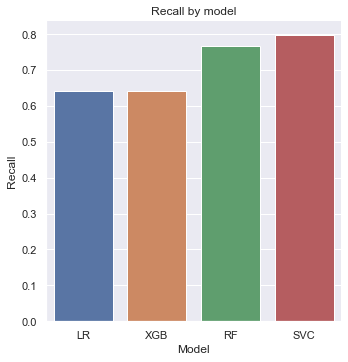

In [125]:
sns.catplot(data=scores_df, kind="bar",x ="Model", y="Recall").set(title="Recall by model")

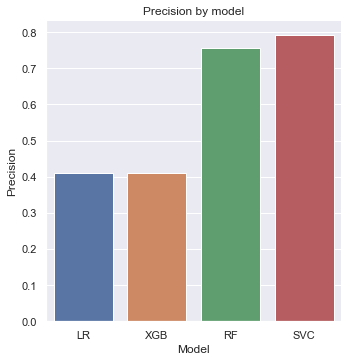

In [126]:
sns.catplot(data=scores_df, kind="bar",x ="Model", y="Precision").set(title="Precision by model")

## Conclusion

From the bar plots above, we see that SVM SVC has the best accuracy, precision and recall score of all the models, although it too cannot distinguish the positive comments from the rest. So I would pick SVM/SVC as the most adequate model for this dataset. To further improve the results we can use Deep Learning techniques.

## References

https://medium.com/swlh/tweet-sentiment-analysis-using-python-for-complete-beginners-4aeb4456040

https://www.kaggle.com/nkitgupta/text-representations

https://www.kaggle.com/seungbumlim/twitter-sentiment-analysis-eda-and-ml-dl